# Exercise 08

## Changes to the Evacuation Model

To enable exercises about sensing and interaction, the evacuation model has been modified:

* Bug fix in `agent.cooperate` (not turning if there is not more than one other agent in the room)
* New model and agent parameter `maxsight`
* Changes in `agent.explore_fieldofvision` to consider `maxsight`
* New switch `DISTANCE_NOISE` to add noise to the calculation of distances to exits (`* self.model.rng.normal(loc=1.0, scale=2.0)`)
* New model parameters `interact_neumann2`, `interact_moore2` and `interact_swnetwork` and agent parameter `interactionmatrix` (combining the three before-mentioned), which indicate the probability of passing alarm message via the particular topology.
* When one of `interact_neumann2`, `interact_moore2` and `interact_swnetwork` is not `None` initially only one agent knows about the alarm.
* With a probabilty of 0.1 each agent who is not alarmed gets alarmed (otherwise the room would never be evacuated if an agent is not informed).
* Adding `net.NetworkGrid`

## Evaluation Code


In [1]:
from mesa.batchrunner import batch_run
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.insert(0,'../../abmodel')

from fire_evacuation.model import FireEvacuation
from fire_evacuation.agent import Human


unikcolors = [np.array((80,149,200))/255, np.array((74,172,150))/255,
                                                  np.array((234,195,114))/255, np.array((199,16,92))/255]
uniks = LinearSegmentedColormap.from_list( 'unik', unikcolors)

%matplotlib inline

# Task 2 (Sensing in the evacuation model)

## Subtask 2.2

We can change an agents sensing by limiting the field of vision, which is applied when agents search for exits and others to help. Explore the model's sensitivity towards the `maxsight` parameter with batch runs. Produce a figure (consult e.g. exercise 07 task 2.4) showing final values of `TurnCount` and `Step` for increasing values of `maxsight`. Also conduct further simulations with a higher proportion (e.g. 0.5) of agents _not_ believing alarm. Discuss (i.e. contextualise, compare and explain your observations) the results. (<200 words)

In [2]:
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.3,
    alarm_believers_prop=[0.1, 0.5, 0.9],
    maxsight = {2,4,6,8,10,12,14,16},
    seed = range(0,20),
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        data_collection_period = 1,
        iterations = 1,
        max_steps = 500,
)

  0%|          | 0/480 [00:00<?, ?it/s]

In [3]:
data1 = pd.DataFrame(results)[['maxsight', "TurnCount", 'Step', 'seed', 'alarm_believers_prop']].round(decimals=1)
db1 = data1.groupby(['seed','maxsight', 'alarm_believers_prop']).agg("max").groupby(['maxsight', 'alarm_believers_prop']).agg("mean")
db1

TurnCount    Step
maxsight alarm_believers_prop                   
2        0.1                    46213.80  500.00
         0.5                    47537.65  500.00
         0.9                    48672.90  500.00
4        0.1                    25869.45  500.00
         0.5                    29095.70  500.00
         0.9                    33501.20  500.00
6        0.1                     4364.70  426.40
         0.5                     5464.95  461.40
         0.9                     7491.50  500.00
8        0.1                      723.35  217.55
         0.5                      780.75  267.55
         0.9                      832.95  221.70
10       0.1                      482.65  181.55
         0.5                      433.15  175.90
         0.9                      513.30   83.30
12       0.1                      464.85  149.00
         0.5                      421.05  130.70
         0.9                      524.80   75.75
14       0.1                      480.85  172.00
         0.5                      543.40  138.55
         0.9                      472.85   82.00
16       0.1                      513.10  183.10
         0.5                      353.85  144.50
         0.9                      449.00   66.80

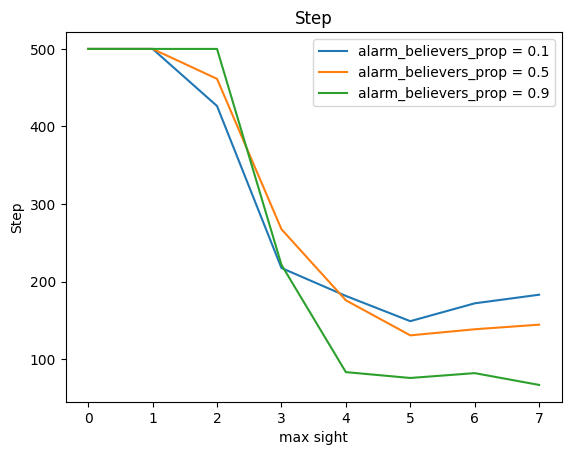

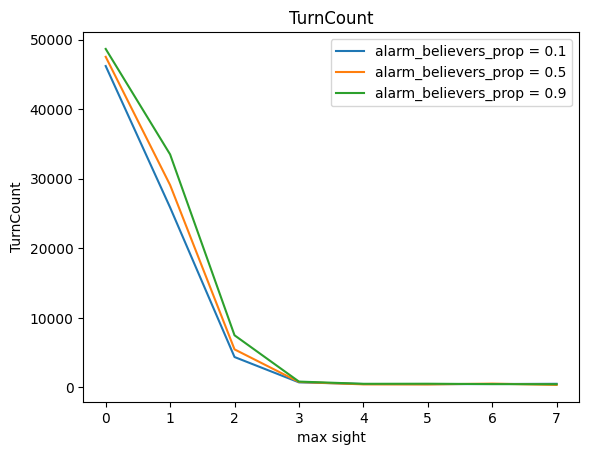

In [4]:
for feature in ['Step', 'TurnCount']:
    plt.xlabel("max sight")
    plt.ylabel(feature)
    for alarm_believers_prop in params['alarm_believers_prop']:
        plt.plot(db1.loc[(slice(None), alarm_believers_prop), :][feature].values, label='alarm_believers_prop = ' + str(alarm_believers_prop))
    plt.title(feature)
    plt.legend()
    plt.show()

# turn count
The higher the maxsight, the lower the turn count. 
This is because the agent can see more exits and other agents, so it can make a better decision on where to go in a long term. 
The turn count is high when the agent has to turn around a lot, because it made a wrong decision having only short distance information available.
However, the turn count is not significantly different for maxsight > 3 since it converges to a lower bound.
The effect of the proportion of belief in the alarm is not significant on the turn count.
The lower the belief in the alarm, the lower the turn count, but the difference is not extreme.
This could be because agents are not informed about the alarm, so they do not change their behavior with regards to an objective.
Informed agents might turn around more often because they are more likely change their direction based on other agent's information, or to help them etc.

# step
It takes longer to evacuate, the lower the maxsight.
This is because the agent can see less exits and other agents, so it takes longer to make a good decision on where to go.

Gernerally, it takes longer to evacuate, the lower the belief in the alarm.
For a high belief in the alarm and a max sight up to 2, the agents evacuate slowest compared to the other belief proportions.
This could be because agents all strive to leave from the same exits (since they can't see far enough to see other exits than their initial one) and thus, cause a congestion.
For max sight >= 3, the biggest alarm believer proportion evacuates fastest. 
This could be because agents evacuate can see more exits and other agents, so they can make a better decision on where to go.
The smallest alarm believer proportion evacuates fastest for max sight <= 3 since they don't cause congestion and can leave while spreading awarness.
For max sight > 4, the smallest alarm believer proportion evacuates the slowest.

## Subtask 2.3

Sensing is often not 100% accurate - uncertainty is involved. A way to represent uncertainty in agent-based modelling is to introduce noise - a random factor that reduces accuracy of the perceived value. Implement random noise for sensing the distance between the agent and a certain exit. Use the (existing) switch to enable/disable noise and define a parameter to calibrate the level of noise. Consider agent heterogeneity! Test your implementation. Does it change results significantly (t-test)?

In [5]:
from IPython.utils import io
        
params = dict(
    floor_size=14,
    human_count=70,
    nervousness_mean = 0.3,
    distancenoise = {False,True},
    distancenoiselevel = 0.4,
    seed = range(100,140),
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        data_collection_period = 1,
        iterations = 1,
        max_steps = 500,
    )
data = pd.DataFrame(results)[['distancenoise', 'Step', 'seed', 'TurnCount']].round(decimals=1)
db = data.groupby(['seed','distancenoise']).agg("max").reset_index()#.groupby(['distancenoise']).agg("mean").reset_index()

  0%|          | 0/80 [00:00<?, ?it/s]

In [6]:
#db

In [7]:
from scipy import stats


for feature in ['Step', 'TurnCount']:

    rvs1 = db.loc[db['distancenoise'] == False, feature].values
    rvs2 = db.loc[db['distancenoise'] == True, feature].values

    _, p_val = stats.ttest_ind(rvs1, rvs2)
    if p_val < 0.1:
        print(feature, p_val, 'is significant')
    else:
        print(feature, p_val, 'is not significant')

Step 0.09755993165378568 is significant
TurnCount 0.49658497071980046 is not significant


## Subtask 2.4

Find two more processes of agents' sensing that could be modelled with uncertainty. How would you introduce uncertainty (provide pseudo code)? Discuss whether you should add this option to the model code (<200 words)!

# process 1: sensing the number of agents in the neighbourhood -> crowd anxiety/ nervousness/ panic
The agent could sense the number of agents in the neighbourhood with a certain uncertainty.
This value influences the agent's anxiety/ nervousness/ panic level.

# process 2: self-awareness of the agent -> level of cooperation
In terms of self-awareness, the agent could sense its own level of cooperation with other agents.
This value influences the agent's cooperation actions.

# Discussion
## process 1
- only realistic if noise depends on value of sensed variable
- models the fact that people in a panic situation might overestimate the number of people close to them
- generally, not useful for the model

## process 2
- not useful for the model
- not applicable to real life

# introduction of uncertainty
- add or multiply noise to the sensed variable
- create noise:
    - noise is normally distributed: 
    ```python
    self.model.rng.normal(loc=1.0, scale=self.distancenoiselevel)
    ```
    - noise is uniformly distributed
    ```python
    np.random.uniform(-1,1)
    ```
    - noise is a constant value (eg. agent needs glasses) generated at the beginning of the simulation
    - noise weighted linear combination of last values and current one
    ```python
    self.cur_feat = np.sum([self.weights[i] * self.last_feats[i] for i in range(len(self.last_feats))], self.weights[-1] * self.cur_feat)
    ```
    - noise increases/ decreases with time or value of the sensed variable
    ```python
    self.distancenoiselevel = self.sensed_val * 0.9
    ```

# Task 3 (Interaction in the evacuation model)

## Subtask 3.1

A new option was added to the model: Assume the fire alarm is broken or not existing, and a single randomly choosen agent gets aware of an incident in the room that requires all to escape. We investigate different ways of interaction in terms of passing the information of fire alarm:

* Propagation in the von-Neumann-neighbourhood 
* Propagation in the Moore-Neighbourhood 
* Propagation on a Small-World-Network (Watts-Beta) 

The model parameters determine the probability by which the information is 	passed from an informed agent to its neighbours on the particular topology.
Execute the code blocks in the notebook and compare the results in a figure (!) and interprete them! For small-world networks, why is the <ins>difference</ins> between low values of 	propagation probability higher than for higher values of the probability?

In [8]:
# Von Neumann:   
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.3,
    cooperation_mean = 0.1,
    interact_neumann = {0.01,0.02,0.05,0.1,0.5,1.0},
    interact_moore = 0.0,
    interact_swnetwork = 0.0,
    seed = range(0,30),
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        data_collection_period = 1,
        iterations = 1,
        max_steps = 500,
    )
data_vn = pd.DataFrame(results)[['interact_neumann', 'interact_moore','interact_swnetwork',
                              'Step', 'TurnCount', 'seed']].round(decimals=2)
db_vn = data_vn.groupby(['seed','interact_neumann','interact_moore','interact_swnetwork',]).agg("max").\
        groupby(['interact_neumann','interact_moore','interact_swnetwork']).agg("mean")
db_vn

  0%|          | 0/180 [00:00<?, ?it/s]

,,,Step,TurnCount
interact_neumann,interact_moore,interact_swnetwork,,
0.01,0.0,0.0,249.366667,625.900000
0.02,0.0,0.0,232.000000,574.133333
0.05,0.0,0.0,220.700000,522.066667
0.10,0.0,0.0,199.800000,498.233333
0.50,0.0,0.0,69.500000,527.066667
1.00,0.0,0.0,56.133333,499.133333


In [9]:
# Moore:
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.3,
    cooperation_mean = 0.1,
    interact_neumann = 0.0,
    interact_moore = {0.01,0.02,0.05,0.1,0.5,1.0},
    interact_swnetwork = 0.0,
    seed = range(0,30),
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        data_collection_period = 1,
        iterations = 1,
        max_steps = 500,
    )
data_mo = pd.DataFrame(results)[['interact_neumann', 'interact_moore','interact_swnetwork',
                              'Step', 'TurnCount', 'seed']].round(decimals=2)
db_mo = data_mo.groupby(['seed','interact_neumann','interact_moore','interact_swnetwork',]).agg("max").\
        groupby(['interact_neumann','interact_moore','interact_swnetwork']).agg("mean")
db_mo

  0%|          | 0/180 [00:00<?, ?it/s]

Step   TurnCount
interact_neumann interact_moore interact_swnetwork                        
0.0              0.01           0.0                 257.200000  548.333333
                 0.02           0.0                 219.466667  520.766667
                 0.05           0.0                 173.066667  472.066667
                 0.10           0.0                 139.433333  493.533333
                 0.50           0.0                  40.600000  481.333333
                 1.00           0.0                  40.166667  538.266667

In [10]:
# Small-world network:
params = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.3,
    cooperation_mean = 0.3,
    interact_neumann = 0.0,
    interact_moore = 0.0,
    interact_swnetwork = {0.01,0.02,0.05,0.1,0.5,1.0},
    seed = range(0,30),
)

results = batch_run(
        FireEvacuation,
        parameters=params,
        data_collection_period = 1,
        iterations = 1,
        max_steps = 500,
    )

data_sw = pd.DataFrame(results)[['interact_neumann', 'interact_moore','interact_swnetwork', 
                              'Step', 'TurnCount', 'seed']].round(decimals=2)
db_sw = data_sw.groupby(['seed','interact_neumann','interact_moore','interact_swnetwork',]).agg("max").\
        groupby(['interact_neumann','interact_moore','interact_swnetwork']).agg("mean")
db_sw

  0%|          | 0/180 [00:00<?, ?it/s]

Step   TurnCount
interact_neumann interact_moore interact_swnetwork                        
0.0              0.0            0.01                156.066667  526.000000
                                0.02                140.333333  534.066667
                                0.05                 92.266667  525.333333
                                0.10                 65.833333  531.833333
                                0.50                 36.800000  546.366667
                                1.00                 36.633333  537.300000

In [11]:
# Some hints to produce a figure
features = ['interact_neumann', 'interact_moore','interact_swnetwork']

# remove columns not needed:
# interact_swnetwork
db_sw.reset_index(inplace=True)
db_sw.drop(["interact_moore", "interact_neumann"], axis=1, inplace=True)
#db_sw.set_index('interact_swnetwork', inplace=True)
# interact_moore
db_mo.reset_index(inplace=True)
db_mo.drop(["interact_swnetwork", "interact_neumann"], axis=1, inplace=True)
#db_mo.set_index('interact_moore', inplace=True)
# interact_neumann
db_vn.reset_index(inplace=True)
db_vn.drop(["interact_moore", "interact_swnetwork"], axis=1, inplace=True)
#db_vn.set_index('interact_neumann', inplace=True)

# rename column to align it to other frames
db_sw.rename(columns={"interact_swnetwork": "interact"}, inplace=True)
db_mo.rename(columns={"interact_moore": "interact"}, inplace=True)
db_vn.rename(columns={"interact_neumann": "interact"}, inplace=True)

# merge DataFrames on 'column' using union of keys from both frames 
plotdata = pd.merge(db_sw, db_mo, how='outer', on='interact', suffixes=("_swnetwork", "_moore"))
plotdata = pd.merge(plotdata, db_vn, how='outer', on='interact', suffixes=("", "_neumann"))
plotdata.rename(columns={"Step": "Step_neumann", "TurnCount": "TurnCount_neumann"}, inplace=True)

# define a column as index (for x-axis of plot)
plotdata.set_index('interact', inplace=True)
plotdata

,Step_swnetwork,TurnCount_swnetwork,Step_moore,TurnCount_moore,Step_neumann,TurnCount_neumann
interact,,,,,,
0.01,156.066667,526.000000,257.200000,548.333333,249.366667,625.900000
0.02,140.333333,534.066667,219.466667,520.766667,232.000000,574.133333
0.05,92.266667,525.333333,173.066667,472.066667,220.700000,522.066667
0.10,65.833333,531.833333,139.433333,493.533333,199.800000,498.233333
0.50,36.800000,546.366667,40.600000,481.333333,69.500000,527.066667
1.00,36.633333,537.300000,40.166667,538.266667,56.133333,499.133333


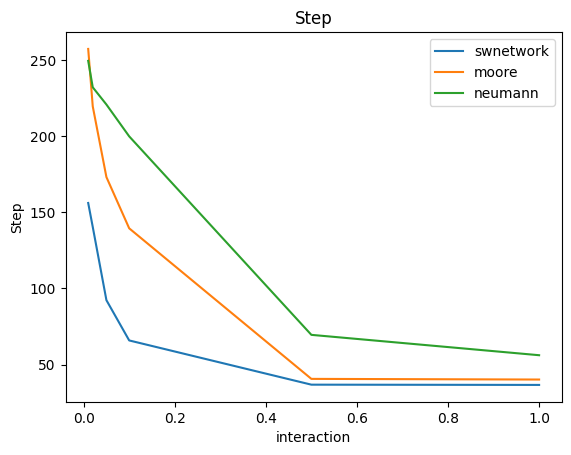

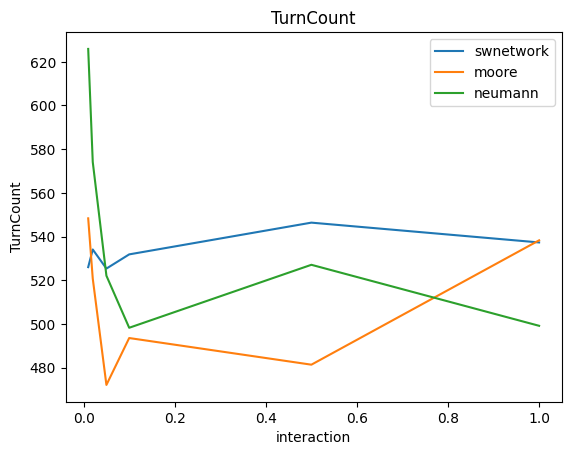

In [12]:
for feature in ['Step', 'TurnCount']:
    suffixes = ["_swnetwork", "_moore", "_neumann"]
    plt.xlabel("interaction")
    plt.ylabel(feature)
    plt.title(feature)
    for suffix in suffixes:
        plt.plot(plotdata[feature + suffix], label=suffix[1:])
    
    plt.legend()
    plt.show()

# steps
- higher values of propagation probability/ interaction -> more agents are informed -> faster evacuation/ less steps
### networks
- small world networks have small average shortest paths, so the information is spread quickly at the beginning
- von neumann has the slowest spread of information and thus, even with high values of the propagation probability, the evacuation takes longer
- both moore and small world networks converge to the same value (0.5) for the number of steps needed to evacuate the room

# TurnCount
- for interaction < 0.05, moore and von neumann have the same trend/ curve (+ offset)
- for interaction > 0.1, small world network and von neumann have the same trend/ curve (+ offset)
- moore: for interaction > 0.5, the curve rises again
- von Neumann: extremest decline


# why does curve for step and small world network has extreme decline at the beginning?
- small world networks have small average shortest paths, so the information is spread quickly at the beginning
- the decline is not as extreme for higher values of the propagation probability because there is a lower bound for the number of steps needed to evacuate the room
    - limited number of exits
    - congestion at exits


## Subtask 3.2

Which initial position would be ideal for each single interaction topology (vonNeumann, Moore, Network)? Format your answer either as list or table.

# von Neumann: 
- maximize information spread: in the middle of the room, but problem: it takes longer to reach the exits
- minimize steps: one tile away from the exit (first step: inform the agent at the exit (and others in neighbourhood) about fire, second step: leave the room, because information spread has started)

# Moore: 
cf. von Neumann

# small world Network: 
high degree nodes, because they have more neighbours and can spread the information faster

## Subtask 3.3

Implement placing the initial knowing agent at a beneficial position for propagation on the smallworld-network. Consider [this answer](https://stackoverflow.com/a/58392749/3957413)!

First describe your idea here in pseudo code, then implement in model.py at line 342ff. Copy and re-run the last part of 3.1 (values for `interact_swnetwork`).

In [13]:
# Small-world network:
params02 = dict(
    floor_size=14,
    human_count=100,
    nervousness_mean = 0.3,
    cooperation_mean = 0.3,
    interact_neumann = 0.0,
    interact_moore = 0.0,
    interact_swnetwork = {0.01,0.02,0.05,0.1,0.5,1.0},
    seed = range(0,30),
    select_initiator = True
)

results02 = batch_run(
        FireEvacuation,
        parameters=params02,
        data_collection_period = 1,
        iterations = 1,
        max_steps = 500,
        number_processes=None
    )

data_sw2 = pd.DataFrame(results02)[['interact_neumann', 'interact_moore','interact_swnetwork', 
                              'Step', 'TurnCount', 'seed']].round(decimals=2)
db_sw2 = data_sw2.groupby(['seed','interact_neumann','interact_moore','interact_swnetwork',]).agg("max").\
        groupby(['interact_neumann','interact_moore','interact_swnetwork']).agg("mean")
db_sw2

  0%|          | 0/180 [00:00<?, ?it/s]

Step   TurnCount
interact_neumann interact_moore interact_swnetwork                        
0.0              0.0            0.01                164.600000  559.966667
                                0.02                120.533333  581.500000
                                0.05                107.466667  480.900000
                                0.10                 70.933333  527.366667
                                0.50                 35.566667  519.766667
                                1.00                 35.966667  488.533333

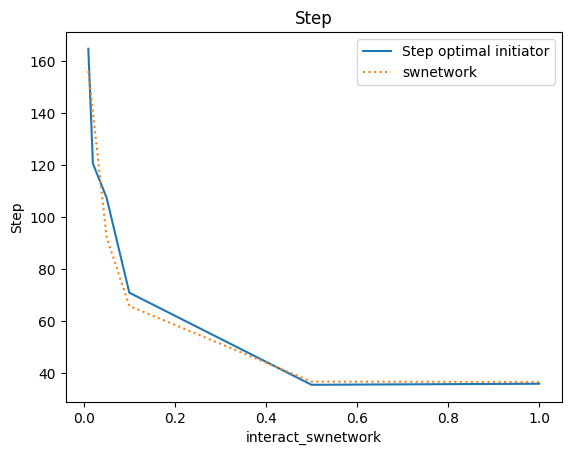

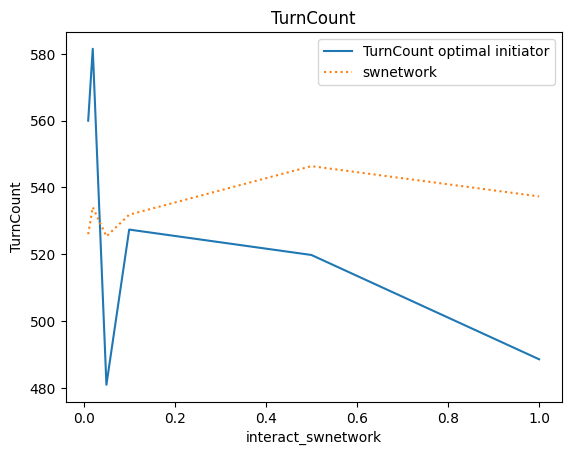

In [14]:
for feature in ['Step', 'TurnCount']:
    plt.xlabel("interact_swnetwork")
    plt.ylabel(feature)
    plt.title(feature)
    db_sw2.reset_index(inplace=True)
    plt.plot(db_sw2['interact_swnetwork'], db_sw2[feature], label=feature + ' optimal initiator')
    suffix = suffixes[0]
    plt.plot(plotdata[feature + suffix], label=suffix[1:], linestyle='dotted')
    
    plt.legend()
    plt.show()

# compare optimal position with random position of initial knowing agent
## steps
almost same plots as in 3.1, no significant difference.


## TurnCount
- optimal position: lower turn count after around 0.05
- optimal position: higher turn count before around 0.05, starts significantly higher than random position